In [15]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import torch
import glob
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


Unique mask values: [0 1 2]


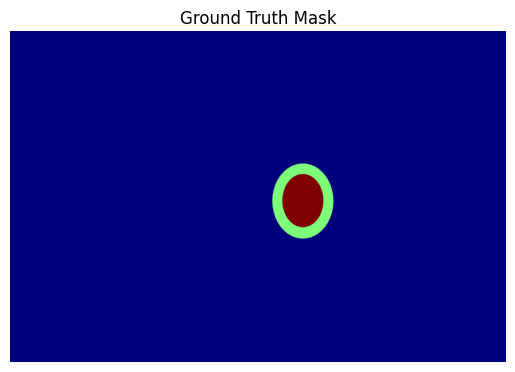

In [16]:
# Sanity check for a single .mat mask
import scipy.io
mat = scipy.io.loadmat(r'ORIGA/ORIGA/Semi-automatic-annotations/001.mat')
mask = mat['mask']
print('Unique mask values:', np.unique(mask))
plt.imshow(mask, cmap='jet', vmin=0, vmax=2)
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()

In [48]:
import random

class ROISegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, crop_size=(256, 256), transform=None, mask_key='mask'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_size = crop_size
        self.transform = transform
        self.mask_key = mask_key

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path).convert('RGB')
        mat = np.load(mask_path) if mask_path.endswith('.npy') else None
        if mat is None:
            from scipy.io import loadmat
            mat = loadmat(mask_path)
        mask = mat[self.mask_key]

        # Ensure mask is uint8
        mask = mask.astype(np.uint8)
        # Resize mask if needed, with NEAREST
        if mask.shape != image.size[::-1]:
            mask_pil = Image.fromarray(mask)
            mask_pil = mask_pil.resize(image.size, resample=Image.NEAREST)
            mask = np.array(mask_pil)

        image = np.array(image)

        # --- Class-aware crop ---
        crop_h, crop_w = self.crop_size
        fg_indices = np.argwhere(mask > 0)  # all non-background pixels

        if len(fg_indices) > 0:
            # Pick a random foreground pixel
            y, x = fg_indices[np.random.randint(len(fg_indices))]
            # Compute crop bounds (ensure inside image)
            y1 = max(0, y - crop_h // 2)
            x1 = max(0, x - crop_w // 2)
            y2 = min(mask.shape[0], y1 + crop_h)
            x2 = min(mask.shape[1], x1 + crop_w)
            # If we're too close to border, adjust
            y1 = y2 - crop_h
            x1 = x2 - crop_w
            y1 = max(0, y1)
            x1 = max(0, x1)
        else:
            # No foreground, fallback to random crop
            y1 = np.random.randint(0, mask.shape[0] - crop_h + 1)
            x1 = np.random.randint(0, mask.shape[1] - crop_w + 1)

        # Crop image and mask
        image_crop = image[y1:y1+crop_h, x1:x1+crop_w, :]
        mask_crop = mask[y1:y1+crop_h, x1:x1+crop_w]

        # To tensor
        image_crop = torch.tensor(image_crop.transpose(2,0,1) / 255.0, dtype=torch.float32)
        mask_crop = torch.tensor(mask_crop, dtype=torch.long)

        if self.transform is not None:
            # Optionally augment image/mask here
            pass

        return image_crop, mask_crop

In [18]:
image_dir = 'ORIGA/ORIGA/roi_images'
mask_dir = 'ORIGA/ORIGA/Semi-automatic-annotations'

image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.mat")))

# Match by basename
image_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in image_paths}
mask_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_paths}
common_names = sorted(set(image_basenames) & set(mask_basenames))
paired_images = [image_basenames[name] for name in common_names]
paired_masks = [mask_basenames[name] for name in common_names]

train_imgs, test_imgs, train_masks, test_masks = train_test_split(
    paired_images, paired_masks, test_size=0.2, random_state=42)

train_dataset = ROISegmentationDataset(train_imgs, train_masks)
test_dataset  = ROISegmentationDataset(test_imgs, test_masks)
train_loader  = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=4, shuffle=False)


Unique values in mask sample: tensor([0, 1, 2])


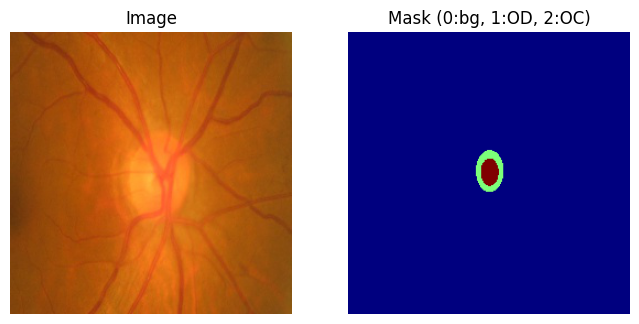

In [19]:
# Visualize a sample pair from the Dataset
img, msk = train_dataset[0]
print('Unique values in mask sample:', torch.unique(msk))
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title('Image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(msk, cmap='jet', vmin=0, vmax=2)
plt.title('Mask (0:bg, 1:OD, 2:OC)')
plt.axis('off')
plt.show()

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2)
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b = self.bottleneck(p2)
        up2 = self.up2(b)
        cat2 = torch.cat([up2, e2], dim=1)
        d2 = self.dec2(cat2)
        up1 = self.up1(d2)
        cat1 = torch.cat([up1, e1], dim=1)
        d1 = self.dec1(cat1)
        out = self.conv_last(d1)
        return out

In [24]:
all_labels = []
for _, mask in train_dataset:
    all_labels.append(mask.numpy().flatten())
all_labels = np.concatenate(all_labels)
print("Label counts:", np.bincount(all_labels))

Label counts: [33540882   339512   198326]


Auto-calculated class weights: tensor([  1.0000,  98.7915, 169.1199])
Epoch 1, Loss: 1.1111
Epoch 10, Loss: 0.8463
Epoch 20, Loss: 1.0693
Epoch 30, Loss: 0.6040
Epoch 40, Loss: 0.5083
Epoch 50, Loss: 0.6319
Epoch 60, Loss: 0.5026
Epoch 70, Loss: 0.4851
Epoch 80, Loss: 0.4483
Epoch 90, Loss: 0.5600
Epoch 100, Loss: 0.6440
Epoch 110, Loss: 1.0846
Epoch 120, Loss: 0.8335
Epoch 130, Loss: 1.5648
Epoch 140, Loss: 1.0879
Epoch 150, Loss: 0.9944
Epoch 160, Loss: 0.6461
Epoch 170, Loss: 1.3046
Epoch 180, Loss: 1.0597
Epoch 190, Loss: 1.0382
Epoch 200, Loss: 0.9637
Epoch 210, Loss: 0.4857
Epoch 220, Loss: 0.5113
Epoch 230, Loss: 1.3635
Epoch 240, Loss: 0.5509
Epoch 250, Loss: 0.4486
Epoch 260, Loss: 0.4153
Epoch 270, Loss: 0.3663
Epoch 280, Loss: 0.4080
Epoch 290, Loss: 0.3241
Epoch 300, Loss: 0.5318
Epoch 310, Loss: 0.2782
Epoch 320, Loss: 2.5164
Epoch 330, Loss: 1.0388
Epoch 340, Loss: 1.0148
Epoch 350, Loss: 0.9492
Epoch 360, Loss: 0.8685
Epoch 370, Loss: 0.7954
Epoch 380, Loss: 0.6615
Epoch

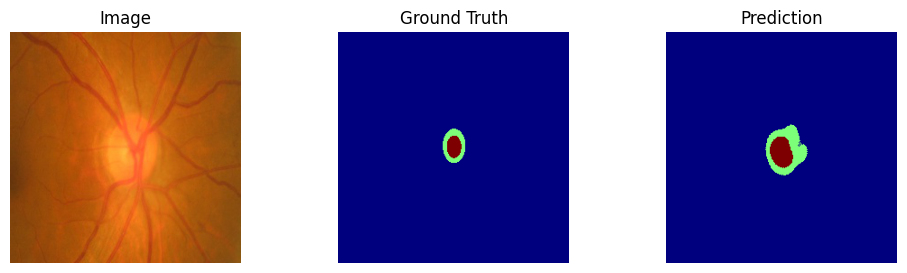

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3).to(device)

# Your class pixel counts
class_counts = torch.tensor([33540882, 339512, 198326], dtype=torch.float32)
num_classes = len(class_counts)
total_pixels = class_counts.sum()

# Compute weights inversely proportional to class frequency
class_weights = total_pixels / (num_classes * class_counts)
class_weights = class_weights / class_weights.min()  # normalize so min weight is 1.0

print("Auto-calculated class weights:", class_weights)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Use only one sample for overfitting
mini_dataset = torch.utils.data.Subset(train_dataset, [0])
mini_loader = DataLoader(mini_dataset, batch_size=1, shuffle=True)

def train_overfit(model, loader, criterion, optimizer, device, epochs=500):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_loss = total_loss / len(loader.dataset)
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

train_overfit(model, mini_loader, criterion, optimizer, device, epochs=500)




Ground truth unique: tensor([0, 1, 2])
Prediction unique: tensor([0, 1, 2])


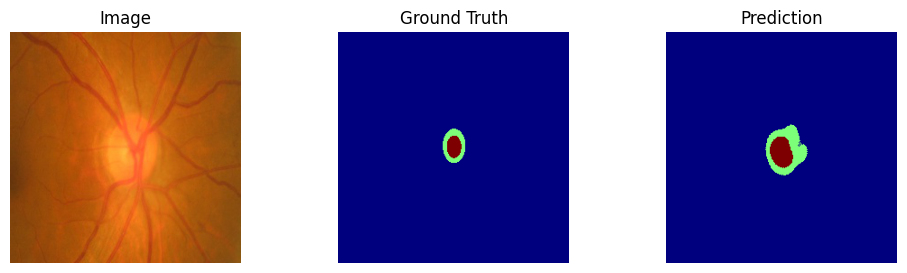

In [54]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(mini_loader))
    images = images.to(device)
    outputs = model(images)
    preds = outputs.argmax(1).cpu()
    images = images.cpu()

import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    print("Ground truth unique:", torch.unique(masks[i]))
    print("Prediction unique:", torch.unique(preds[i]))
    plt.figure(figsize=(12,3))
    plt.subplot(1,3,1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title('Image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(masks[i], cmap='jet', vmin=0, vmax=2)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(preds[i], cmap='jet', vmin=0, vmax=2)
    plt.title('Prediction')
    plt.axis('off')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=3).to(device)
class_counts = torch.tensor([33540882, 339512, 198326], dtype=torch.float32)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)
print("Class weights:", class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_unet(model, loader, criterion, optimizer, device, epochs=1):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # (B, 3, H, W)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * images.size(0)
        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

train_unet(model, train_loader, criterion, optimizer, device, epochs=1)